In [1]:
# reload modules before execution (for the changing code in Src)
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# import helper functions
import sys
import os

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
scripts_path = os.path.join(project_root, 'Src')

if scripts_path not in sys.path:
    sys.path.append(scripts_path)

from simulate import generate_stationary_roots, compute_poly_coeffs_old, compute_poly_coeffs_new, vieta_brute_force, calculate_vietas_coeffs, generate_ar_process
from visualise import plot_roots_with_unit_circle

# Generating a Synthetic Time Series

In time series analysis, an observed series is often represented as the sum of two main components:  

- **Systematic component** – The structured, deterministic part of the series.  
- **Residual correlated noise** – A stochastic process that may exhibit dependence over time.  

The systematic component is typically further decomposed into:

- **Trend** – The long-term directional movement in the data.  
- **Seasonality** – Regular, repeating patterns that occur at fixed intervals.  

The following approach is assumed for generating a **synthetic time series**:

1. Generating a series of **white noise**.  
2. Transforming it into a **correlated process** using an **AR($p$) model**.  
3. Adding a **trend** and **seasonality** to introduce systematic structure.  

## **White Noise**
White noise is a sequence of independent and identically distributed (i.i.d.) random variables, meaning each realization comes from the same distribution and is independent of all others. While a standard normal distribution is a common choice due to its simplicity and mathematical convenience, it is not a strict requirement. The choice of mean, variance, and even distribution is flexible, provided that the white noise remains independent and identically distributed over time.

Here, a series of white noise will be generated as i.i.d. random variables drawn from a standard normal distribution:

$$ \epsilon_t \sim \mathcal{N}(0,1) $$

## **AR($p$) Process**  

An autoregressive process of order $p$, denoted **AR($p$)**, is defined as:  

$$ X_t = \sum_{i = 1}^{p} \phi_i X_{t-i} + \epsilon_t, $$  

where $\epsilon_t$ is white noise.

The stationarity of an **AR($p$) process** is determined by the roots of its **characteristic polynomial**, which can be expressed in two equivalent formulations:  

### **1. Z-transform Representation**

Using the Z-transform, the AR($p$) process can be rewritten as:  

$$ \mathcal{Z}\{X_t\} \left( 1 - \sum_{i=1}^{p} \phi_i z^{-i} \right) = \mathcal{Z}\{\epsilon_t\}, \quad z \in \mathbb{C}. $$  

The characteristic polynomial is then given by:  

$$ 1 - \sum_{i=1}^{p} \phi_i z^{-i} = 0. $$  

Multiplying both sides by $z^p$ yields a polynomial form:  

$$ z^p - \sum_{i=1}^{p} \phi_i z^{p-i} = 0. $$  

For the AR($p$) process to be **stationary**, all solutions (roots) of this characteristic equation must lie **inside** the unit circle:  

$$ \forall_i \quad |z_i| < 1. $$  

For the process to remain **real-valued**, the polynomial's roots must satisfy:  

- Any complex roots must occur in **conjugate pairs**.  
- If $p$ is odd, at least one root must be **real**.  

These conditions ensure that the **coefficients** $\phi_i$ remain real.  

### **2. Backshift Operator Representation**  

The **backshift operator** $L$ is defined as:  

$$ L^k X_t = X_{t-k}. $$  

Rewriting the AR($p$) equation in terms of $L$:  

$$ \left(1 - \sum_{i=1}^{p} \phi_i L^i \right) X_t = \epsilon_t. $$  

The characteristic polynomial is then:  

$$ 1 - \sum_{i=1}^{p} \phi_i L^i = 0, $$  

which is equivalent to the Z-transform formulation, where $L$ corresponds to $z^{-1}$.  

The **stationarity condition** in this form requires that **all roots lie outside the unit circle**:  

$$ \forall_i \quad |L_i| > 1. $$  

### **Generating an AR($p$) Process**

To generate an AR($p$) process using the **Z-transform formulation**:

1. **Generate the roots ensuring stationarity**  
   Generate the roots $\{z_i\}_{i=1}^p$ of the characteristic polynomial in the **Z-transform domain**, ensuring that they lie **inside** the unit circle:

   $$ \forall_i \quad |z_i| < 1. $$

2. **Compute AR Coefficients via Vieta’s Formulas**  
   The characteristic polynomial associated with the AR($p$) process is given by:

   $$ z^p - \sum_{i=1}^{p} \phi_i z^{p-i} = 0. $$

   In its factored form:

   $$ \prod_{i=1}^{p} (z - z_i) = z^p + a_1 z^{p-1} + a_2 z^{p-2} + \dots + a_p = z^p - \phi_1 z^{p-1} - \phi_2 z^{p-2} - \dots - \phi_p. $$

   Expanding the left-hand side and matching coefficients term by term, the AR coefficients $\phi_i$ are obtained:

   $$ a_1 = -\sum_{i=1}^{p} z_i, $$

   $$ a_2 = \sum_{1 \le i < j \le p} z_i z_j, $$

   $$ a_3 = -\sum_{1 \le i < j < k \le p} z_i z_j z_k, $$

   and so forth, alternating signs. In general:

   $$ a_m = (-1)^{m} \sum_{1 \le i_1 < i_2 < \dots < i_m \le p} z_{i_1} z_{i_2} \dots z_{i_m}. $$

   These coefficients follow Vieta’s relations, assuming a monic polynomial (i.e., the leading coefficient is 1).

   Then $\phi_1 = -a_1$, $\phi_2 = -a_2$ and so on.

4. **Simulate the AR($p$) Process**  
   Given the computed **AR coefficients** $\phi_1, \phi_2, \dots, \phi_p$ and a **white noise process** $\{\epsilon_t\}$:

   - Initialize $X_1, \dots, X_p$ to zeros.
   - Compute:

     $$ X_t = \sum_{i=1}^{p} \phi_i X_{t-i} + \epsilon_t, \quad t = p+1, p+2, \dots $$

   - To obtain a time series of length $T$, generate $T+M$ data points and discard the first $M$ values to remove the influence of initial conditions.
   - Set $M = 10p$ to ensure minimal impact from initialization.  

This procedure yields a **stationary** AR($p$) time series $\{X_t\}$ based on the **Z-transform formulation**.

## Time frame choice

In [7]:
# Y years of daily data
Y = 3
# My year temporarily has 10 days so it's easier to check
# TODO chage to 365
N = 10 * Y
start_date = pd.to_datetime("2020-01-01")
date_index = pd.date_range(start = start_date, periods = N, freq = 'D')
synth_ts = pd.DataFrame(index = date_index)

## Stationary AR(p)

### Generate roots

[-0.43083296+0.16004238j -0.43083296-0.16004238j  0.23161656+0.j        ]


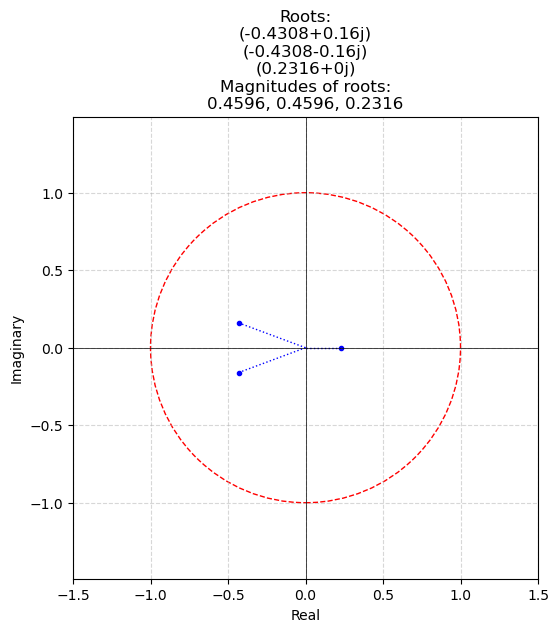

In [8]:
p = 3
roots = generate_stationary_roots(p)
print(roots)
plot_roots_with_unit_circle(roots)

### Compute coefficients

In [9]:
def check_coefs(func, root_set):
    for roots in root_set:
        print(func(roots))

In [11]:
n_runs = 1
root_set = [generate_stationary_roots(3) for _ in range(n_runs)]
for n in range(n_runs):
    check_coefs(compute_poly_coeffs_old, root_set)
    check_coefs(compute_poly_coeffs_new, root_set)
    check_coefs(calculate_vietas_coeffs, root_set)
    check_coefs(vieta_brute_force, root_set)

[-0.51242482  0.09228303 -0.00584791]
[-0.51242482+0.j  0.09228303+0.j -0.00584791+0.j]
[np.complex128(-0.5124248224632321+0j), np.complex128(0.09228302641403231+0j), np.complex128(-0.005847913830822576+0j)]
[np.complex128(-0.5124248224632321+0j), np.complex128(0.09228302641403231+0j), np.complex128(-0.005847913830822576+0j)]


In [12]:
def benchmark_function_on_fixed_roots(func, random_roots_sets):
    for roots in random_roots_sets:
        coeffs = func(roots)

In [14]:
import timeit
n_runs = 100
root_set = [generate_stationary_roots(10) for _ in range(n_runs)]

print(timeit.timeit(lambda: benchmark_function_on_fixed_roots(vieta_brute_force, root_set), number = n_runs))
print(timeit.timeit(lambda: benchmark_function_on_fixed_roots(calculate_vietas_coeffs, root_set), number = n_runs))
print(timeit.timeit(lambda: benchmark_function_on_fixed_roots(compute_poly_coeffs_old, root_set), number = n_runs))
print(timeit.timeit(lambda: benchmark_function_on_fixed_roots(compute_poly_coeffs_new, root_set), number = n_runs))

7.045126658000299
0.2681881379994593
0.6376847009996709
1.957700848000968


### Generate the AR(p) process driven by standard normal noise

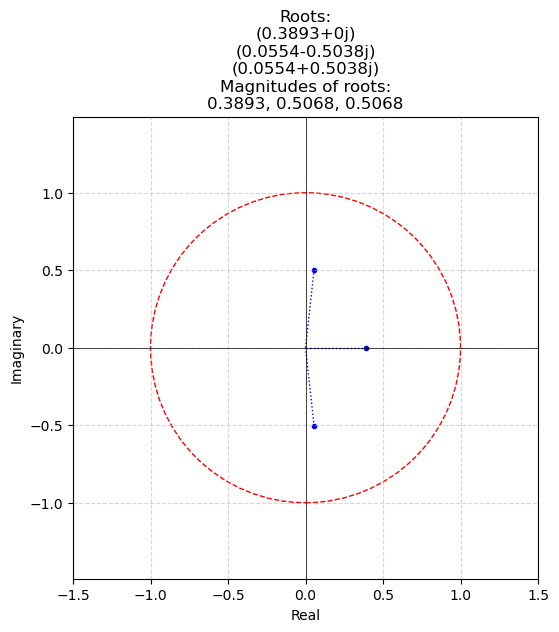



[ 0.5000004 -0.j -0.30000055-0.j  0.10000029-0.j]


Augmented Dickey-Fuller Test:
Test Statistic: -13.7293
p-value: 0.0000
Critical Values:
  1%: -3.4369
  5%: -2.8644
  10%: -2.5683

KPSS Test:
Test Statistic: 0.0751
p-value: 0.1000
Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390


/tmp/ipykernel_5115/2465098150.py:32: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(x, regression = 'c', nlags = 'auto')


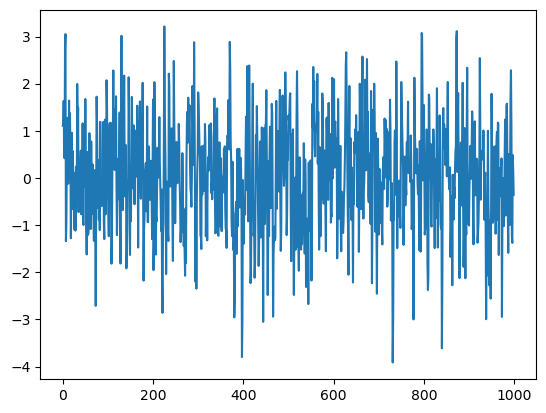

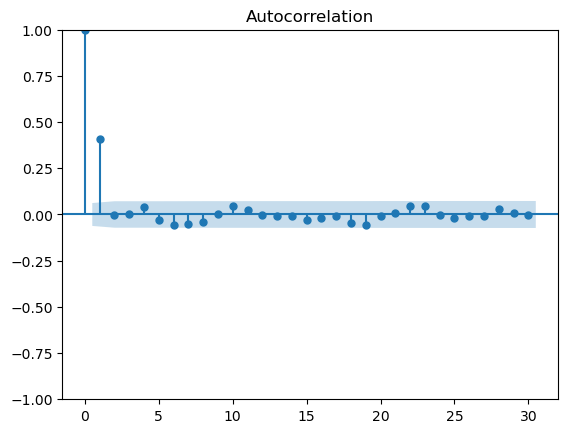

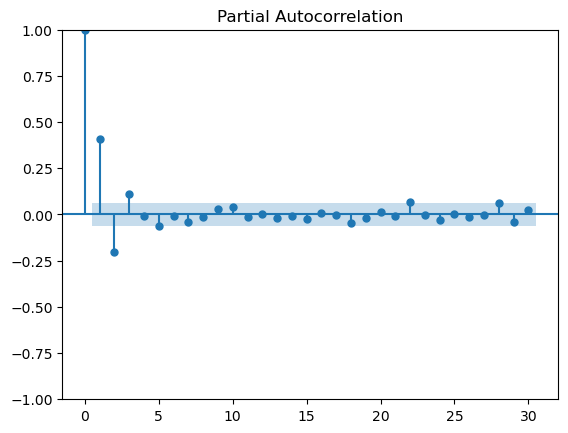

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

# Example: Generate stationary roots for AR(p)
p = 3
#roots = generate_stationary_roots(p)
roots = [0.389265, 0.0553677-0.503815j, 0.0553677+0.503815j]
plot_roots_with_unit_circle(roots)
#print("Generated roots:", roots)
#print("Magnitudes of roots:", np.abs(roots))

coef = calculate_vietas_coeffs(roots)
ar_coef = np.array([-c for c in coef])

if not np.all(ar_coef.imag == 0):
    print("\nCoefficient are complex.\n")

print("\n")
print(ar_coef)
print("\n")

x, noise = generate_ar_process(ar_coef.real, 1000)

adf_result = adfuller(x)
print("Augmented Dickey-Fuller Test:")
print(f"Test Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.4f}")

kpss_result = kpss(x, regression = 'c', nlags = 'auto')
print("\nKPSS Test:")
print(f"Test Statistic: {kpss_result[0]:.4f}")
print(f"p-value: {kpss_result[1]:.4f}")
print("Critical Values:")
for key, value in kpss_result[3].items():
    print(f"  {key}: {value:.4f}")

plt.plot(x)
# TODO add a title with AR formulation
plt.show()

plot_acf(x)
plt.show()
plot_pacf(x)
plt.show()

# TODO do tests on going from roots -> coeficients through reverse calculating roots

## Trend

In [49]:
# Generate a trend
if N % 2 == 0:
    adj_to_center = N/2
else:
    adj_to_center = (N - 1)/2
synth_ts["t"] = np.arange(N) - adj_to_center
synth_ts["t2"] = synth_ts["t"]**2

In [50]:
synth_ts

,noise,t,t2
2020-01-01,-0.952578,-15.0,225.0
2020-01-02,0.357504,-14.0,196.0
2020-01-03,1.687633,-13.0,169.0
2020-01-04,0.264103,-12.0,144.0
2020-01-05,2.673997,-11.0,121.0
2020-01-06,-0.481717,-10.0,100.0
2020-01-07,-0.542504,-9.0,81.0
2020-01-08,-0.637542,-8.0,64.0
2020-01-09,0.178654,-7.0,49.0
2020-01-10,-0.983914,-6.0,36.0
